# Clustering text documents using k-means 



In this notebook, we use the Kmeans algorithm and de MiniBatchKMeans algorithm to cluster text documents. We use the 20 newsgroups dataset, which is a collection of approximately 18,000 newsgroup documents, partitioned across 20 different topics. We will use the text of the topics to cluster the documents into 20 clusters, one for each.

We start loading the modules for data structure, data manipulation, and visualization, also, load de 20 newsgroups dataset, models, tokenizers, and vectorizers, operations like normalization and metrics.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer



when all the modules are loaded, we do the ETL process, starting with extracting process, putting all data into dataset variable and creating the categories. We remove the headers, footers, and quotes from the text.

In [4]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)



In this particular case, we have all the observations labeled, so we can use the labels to evaluate the performance of the clustering algorithms and get the quality of the clusters. We use *np.unique* to get the unique labels and *shape* to get the number of unique labels.

In [5]:
labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In order to continue, we define the *fit and evaluate* function, which receives the model, the data, and title of the results. The function fits the model with the data and evaluates the performance of the model using the *homogeneity_score*, *completeness_score*, and *v_measure_score* metrics. The function returns the scores and time taken to fit the model.

In [6]:
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

in the same way, we continue with the ETL process, now doing the Transform stage, we use the *TfidfVectorizer* to convert the text into a matrix of TF-IDF features, we use the *fit_transform* method to fit the model and transform the data.

In [7]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.579 s
n_samples: 3387, n_features: 7929


In [8]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


First, for the Kmeans algorithm, we use the *KMeans* class to create the model, we set the number of clusters to 20, and the number of iterations to 1000, we use the *fit* method to fit the model with the data.


In [9]:
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [ 481  675 1785  446]
Number of elements assigned to each cluster: [1689  638  480  580]
Number of elements assigned to each cluster: [   1    1    1 3384]
Number of elements assigned to each cluster: [1887  311  332  857]
Number of elements assigned to each cluster: [ 291  673 1771  652]

True number of documents in each category according to the class labels: [799 973 987 628]


to avoid the posibility of unbalanced clusters, we change the number of independiant initials cetoids to 5 and run the model.

In [10]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")


clustering done in 0.23 ± 0.05 s 
Homogeneity: 0.349 ± 0.010
Completeness: 0.398 ± 0.009
V-measure: 0.372 ± 0.009
Adjusted Rand-Index: 0.203 ± 0.017
Silhouette Coefficient: 0.007 ± 0.001


When we reduce the dimensionality of the data, use the n_init parameter to 1 and get stability in the clusters.

Using LSA to reduce the dimensionality of the data, we call the *TruncatedSVD* class to create the model, we set the number of components to 100, and use the *normalizer* with copy to False, we use the *fit_transform* method to fit the model and transform the data.

In [11]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 2.299 s
Explained variance of the SVD step: 18.4%


then setup the Kmeans model with the new data and fit the model.

Finally, we evaluate the performance of the models using the *fit and evaluate* function, we get the scores and time taken to fit the models.

In [12]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.03 ± 0.01 s 
Homogeneity: 0.405 ± 0.004
Completeness: 0.444 ± 0.015
V-measure: 0.423 ± 0.006
Adjusted Rand-Index: 0.318 ± 0.014
Silhouette Coefficient: 0.030 ± 0.000


We can see that the Kmeans algorithm increases the performance when we reduce the dimensionality of the data, the homogeneity score increases from 0.349 to 0.399, the completeness score increases from 0.398 to 0.444, and the v-measure score increases from 0.372 to 0.42.

In the same way, we use the MiniBatchKMeans algorithm to cluster the text documents, we use the *MiniBatchKMeans* class to create the model, we set the number of clusters to 20, the number of iterations to 1000, and the batch size to 1000, we also fit the model with the data.

In [13]:
minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the env

clustering done in 0.20 ± 0.19 s 
Homogeneity: 0.353 ± 0.077
Completeness: 0.372 ± 0.058
V-measure: 0.361 ± 0.069
Adjusted Rand-Index: 0.321 ± 0.080
Silhouette Coefficient: 0.026 ± 0.006


As TF-IDF is invertible, we can get the most important words for each cluster, we use the *argsort* method to get the indices of the most important words, and the *get_feature_names* method to get the words.

In [14]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: space launch orbit shuttle nasa moon earth like mission cost 
Cluster 1: just think don like know time say ve does did 
Cluster 2: thanks graphics image files file program know looking help format 
Cluster 3: god people jesus bible don believe say religion think christian 


At last, but not least, we can vectorize through hashes, we use the *HashingVectorizer* to convert the text into a matrix of TF-IDF features, we set the number of features to 2^18, *TfidfTransformer* to normalize the data, *TruncatedSVD* to reduce the dimensionality of the data, and *Normalizer* to normalize the data.

In [15]:
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 4.621 s


We run again the last Kmeans model with the current data and evaluate the performance of the model.

In [16]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.03 ± 0.02 s 
Homogeneity: 0.386 ± 0.015
Completeness: 0.426 ± 0.028
V-measure: 0.405 ± 0.021
Adjusted Rand-Index: 0.320 ± 0.019
Silhouette Coefficient: 0.029 ± 0.001


and the MiniBatchKMeans model too.

In [17]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the env

clustering done in 0.08 ± 0.02 s 
Homogeneity: 0.345 ± 0.056
Completeness: 0.367 ± 0.060
V-measure: 0.355 ± 0.057
Adjusted Rand-Index: 0.305 ± 0.053
Silhouette Coefficient: 0.029 ± 0.003


c:\Users\Alfredo\anaconda3\envs\pr1_ml_escom\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Finally, we can observe al de metrics results and time taken to fit the models in two graphs, comparing homogeneity, completeness, and v-measure scores, adjusted rand index, and silhouette coefficient.

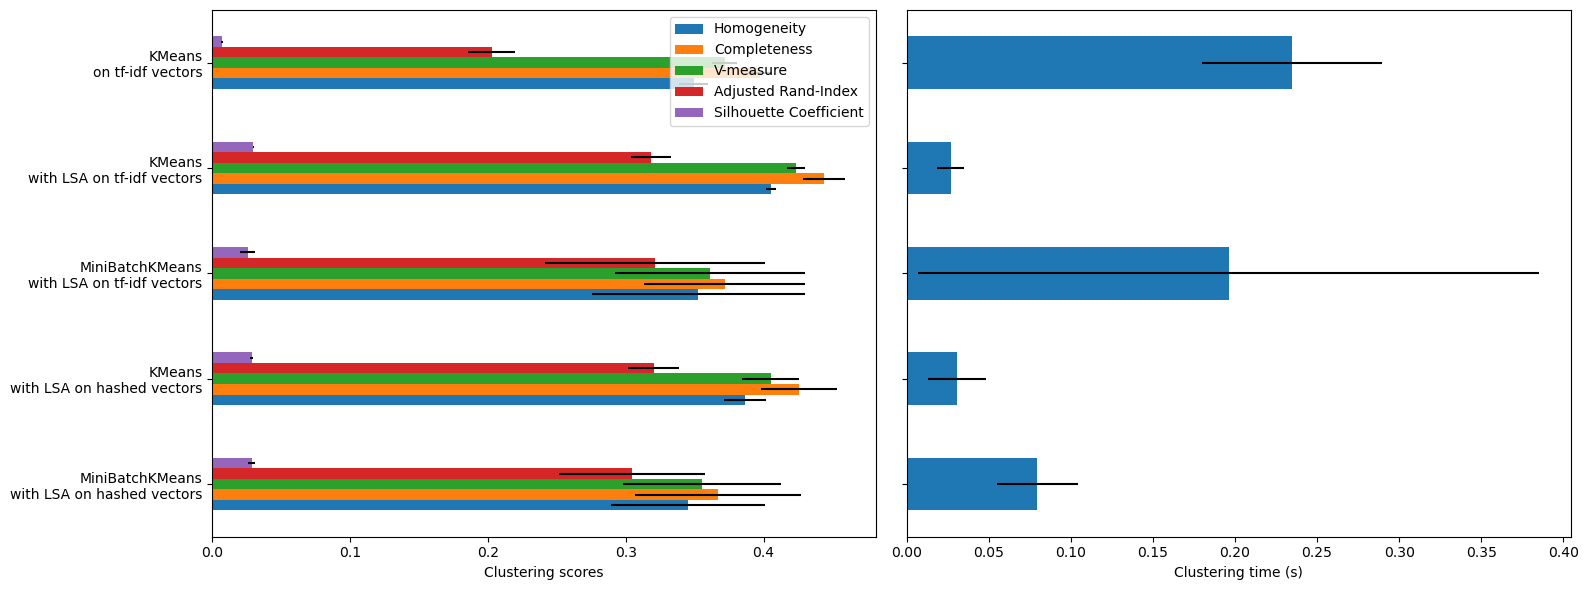

In [18]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

>[!IMPORTANT]
>This exercise is based on the following scikit-learn example: [Clustering text documents using k-means](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

>[!NOTE]
> License: BSD 3 clause
> Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
> Lars Buitinck
> Olivier Grisel <olivier.grisel@ensta.org>
> Arturo Amor <david-arturo.amor-quiroz@inria.fr>